# Generate background pseudo-absence data

In [13]:
############### CHANGE THESE TO YOUR LIKING ###############

specie = 'leptocybe-invasa' # 'thaumastocoris-peregrinus' # 
training = 'east-asia' # 'australia' # 
interest = 'south-east-asia'
count = 10000
# 100m ~ 0.001 deg
# 1000m ~ 0.01 deg
ref_res = (0.01, 0.01) # deg

savefig = False

###########################################################

In [14]:
import os

import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rioxr

import geowombat as gw
from geowombat.data import rgbn
from geocube.api.core import make_geocube

import elapid as ela

import matplotlib.pyplot as plt
import matplotlib as mpl

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shapereader

import warnings
warnings.filterwarnings("ignore")

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [15]:
projection = ccrs.PlateCarree()

def make_map(projection, res, figsize=None, ncols=None):
    
    if ncols == None:
        fig = plt.figure(figsize=figsize)
        axes = [plt.axes(projection=projection)]
    else:
        fig, axes = plt.subplots(figsize=figsize, ncols=ncols, subplot_kw={'projection': projection})
    
#     axes = axes.ravel()
    for ax in axes:
        ax.add_feature(cfeature.BORDERS.with_scale(res)) # , color='gray'
        ax.add_feature(cfeature.STATES.with_scale(res),
                       linestyle=':', edgecolor='gray', linewidth=0.5)
        ax.add_feature(cfeature.LAND.with_scale(res), color='lightgray')
        ax.add_feature(cfeature.COASTLINE.with_scale(res))

#     plt.tight_layout()
    
    return fig, axes

In [16]:
# data_path = os.path.join(os.sep, 'scratch', 'aciar-fst', 'data')
data_path = os.path.join(os.path.dirname(os.getcwd()), 'data')
figs_path = os.path.join(os.path.dirname(os.getcwd()), 'figs')
docs_path = os.path.join(os.path.dirname(os.getcwd()), 'docs')
out_path = os.path.join(os.path.dirname(os.getcwd()), 'out', specie)
input_path = os.path.join(out_path, 'input')
train_path = os.path.join(input_path, 'train')
test_path = os.path.join(input_path, 'test')

In [17]:
regions = {
    'east-asia': ['China', 'Taiwan', 'Japan', 'North Korea', 'South Korea'],
    'south-east-asia': ['Brunei', 'Myanmar', 'Cambodia', 'East Timor', 'Indonesia', 'Laos', 'Malaysia', 'Philippines', 'Singapore', 'Thailand', 'Vietnam'],
    'australia': ['Australia']
}

In [18]:
# Load shapefiles of countries
# select and combine countries in one dataframe
gdf_countries = {}
for region in [training, interest]:
    file_path = train_path if region == training else test_path
    gdf_countries[region] = gpd.read_file(os.path.join(file_path, '%s.shp' %region))

## Load presence/ occurence data

In [19]:
occurences = {}
for region in [training, interest]:
    file_path = train_path if region == training else test_path
    occurences_file_name = os.path.join(file_path, '%s_presence_%s.csv' %(specie, region))
    df = pd.read_csv(occurences_file_name)
    occurences[region] = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
    
    # covert region shape file to tif 
    shpfile = gpd.read_file(os.path.join(file_path, '%s.shp' %region))
    grid = make_geocube(shpfile,resolution=(0.05, -0.05))
    grid.rio.to_raster(os.path.join(file_path, '%s.tif' %region))

## 1. Random

In [20]:
# generate randomly distributed background points
pseudoabsence_random = {}
raster_files = {}
for region in [training, interest]:
    
    file_path = train_path if region == training else test_path

    raster_files[region] = os.path.join(file_path, '%s.tif' %region)
#     raster_files[region] = os.path.join(file_path, 'srtm_%s.tif' %region)

    pseudoabsence_random[region] = ela.sample_raster(raster_files[region], count=count)

    print('Number of presences in %s is: %s' %(region, len(occurences[region])))
    print('Number of random selected background points in %s is: %s' %(region, len( pseudoabsence_random[region])))
    
    # save background point to file
    pseudoabsence_random[region] = pseudoabsence_random[region].to_frame(name='geometry')
    pseudoabsence_random[region]['lon'] = pseudoabsence_random[region]['geometry'].x
    pseudoabsence_random[region]['lat'] = pseudoabsence_random[region]['geometry'].y
    pseudoabsence_random[region].to_csv(os.path.join(file_path, '%s_background_random_%s.csv' %(specie, region)), columns=['lon', 'lat'], index=False)

Number of presences in east-asia is: 36
Number of random selected background points in east-asia is: 10000
Number of presences in south-east-asia is: 11
Number of random selected background points in south-east-asia is: 10000


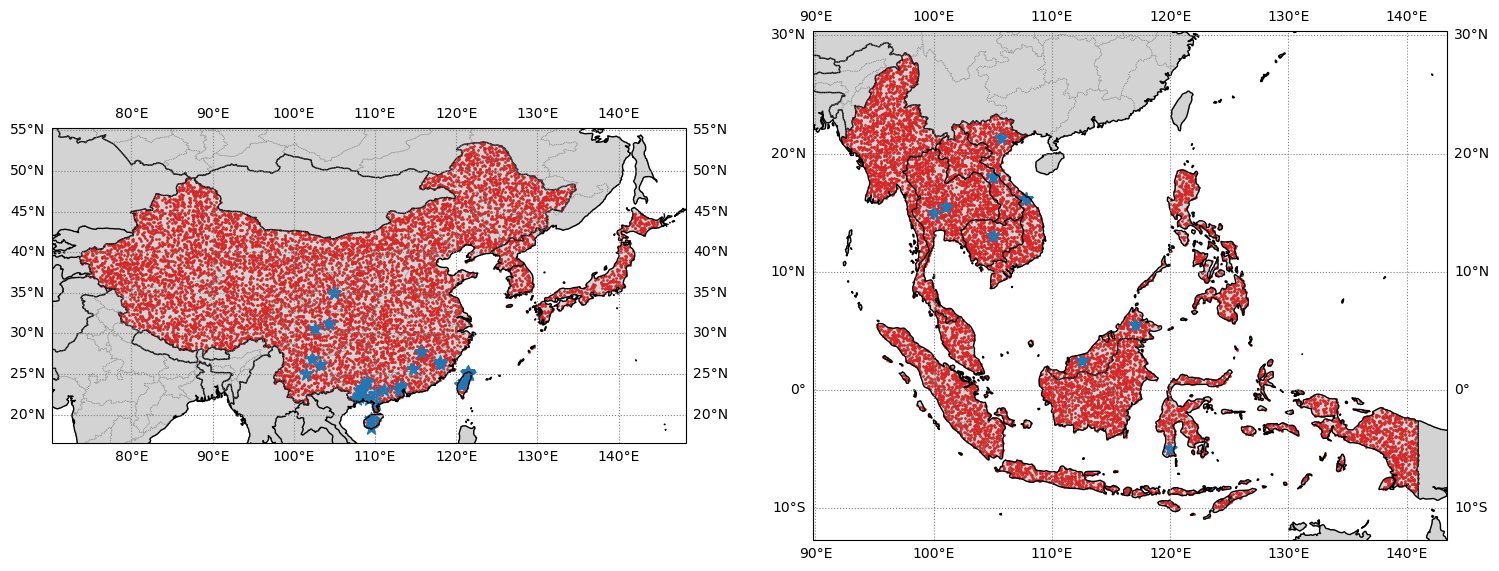

In [21]:
resolution = '50m'
fig, axes = make_map(figsize=(18,10), ncols=2, projection=projection, res=resolution)
# ax = axes[0]
pseudoabsence_random[training].plot(ax=axes[0], markersize=1, color='tab:red')
occurences[training].plot(ax=axes[0], marker='*', markersize=100, color='tab:blue')

pseudoabsence_random[interest].plot(ax=axes[1], markersize=1, color='tab:red')
occurences[interest].plot(ax=axes[1], marker='*', markersize=100, color='tab:blue')

for ax in axes:
    ax.gridlines(color='grey', linestyle=':', draw_labels=True, rotate_labels=False) #ylocs=[-45, -60, -75])

In [ ]:
if savefig:
    fig.savefig(os.path.join(figs_path, '02_background_random_%s.png' %specie), transparent=True)

In [22]:
# region='south-east-asia'

# fig, ax = plt.subplots(figsize=(8, 6))

# gdf_countries[region].plot(ax=ax, facecolor='lightgray', edgecolor='k')
# pseudoabsence_random[region].plot(ax=ax, markersize=1, color='tab:red', label='background')
# occurences[region].plot(ax=ax, marker='*', markersize=100, color='tab:blue', label='presence')

# ax.axis('off')
# ax.set_title('Background and presence points')
# # ax.legend(loc='lower left')
# ax.legend(loc='upper right')
# fig.savefig(os.path.join(docs_path, '02_background-points_random_%s.png' %region), transparent=True, dpi=600)

# fig, ax = plt.subplots(figsize=(8, 6))

# gdf_countries[training].plot(ax=ax, facecolor='lightgray', edgecolor='k')
# pseudoabsence_random[training].plot(ax=ax, markersize=1, color='tab:red')

# ax.axis('off')
# fig.savefig(os.path.join(docs_path, '02_background-points_random_%s.png' %training), transparent=True, dpi=600)

## 2. Biased towards host specie

### 2.1 Biased towards Tree-Type based on Copernicus land cover dataset
https://land.copernicus.eu/global/products/lc


In [23]:
land_cover_file = os.path.join(data_path, 'land-cover', 'PROBAV_LC100_global_v3.0.1_2019-nrt_Forest-Type-layer_EPSG-4326.tif')
land_cover_glo = rioxr.open_rasterio(land_cover_file, masked=True)

# subset global dataset to regions
for region in [training, interest]:

    raster = rioxr.open_rasterio(raster_files[region], masked=True)

    land_cover_box = land_cover_glo.rio.clip_box(
        minx=raster.x.min() - 1,
        miny=raster.y.min() - 1,
        maxx=raster.x.max() + 1,
        maxy=raster.y.max() + 1,
    )
    
    land_cover_box_file = os.path.join('temp', 'land-cover_box_%s.tif' %region)
    if not os.path.exists('temp'):
        os.makedirs('temp')
    land_cover_box.rio.to_raster(land_cover_box_file)
    land_cover_box.close()
land_cover_glo.close()

# regrid regional datasets to coarser grid
land_cover_regions = {}
for region in [training, interest]:
    
    file_path = train_path if region == training else test_path
    land_cover_box_file = os.path.join('temp', 'land-cover_box_%s.tif' %region)
    land_cover_output_file = os.path.join('temp', 'land-cover_%s.tif' %region)
    shapes = [shape for shape in gdf_countries[region].geometry]
    
    with gw.config.update(ref_res=ref_res):
        with gw.open(land_cover_box_file, resampling="bilinear", nodata=255, chunks=1024) as src:
            data = src.isel(band=0).rio.clip(geometries=shapes)
            data.rio.to_raster(land_cover_output_file)

    # load forest type for regions
    land_cover_regions[region] = rioxr.open_rasterio(land_cover_output_file, mask_and_scale=True).isel(band=0)

In [24]:
# forest type land cover dataset
# indicate likelihood that specie occurs in Forest type with a number between 0 and 1
forest_dict = {
    0: ['N/K', 'Unknown', 0, 'white'],
    1: ['ENF', 'Evergreen Needleleaf Forest', 0.8, 'red'],
    2: ['EBF', 'Evergreen Broadleaf Forest', 1.0, 'orange'],
    3: ['DNF', 'Deciduous Needleleaf Forest', 0.2, 'green'],
    4: ['DBF', 'Deciduous Broadleaf Forest', 0.4, 'blue'],
    5: ['MF', 'Mixed Forest', 0.5, 'purple']}

print("\033[1mWeighted values:\033[0m")
for key, val in forest_dict.items():
    print(val[1],':', val[2])


Weighted values:
Unknown : 0
Evergreen Needleleaf Forest : 0.8
Evergreen Broadleaf Forest : 1.0
Deciduous Needleleaf Forest : 0.2
Deciduous Broadleaf Forest : 0.4
Mixed Forest : 0.5


In [25]:
land_cover_bias_file_names = {}
for region in [training, interest]:

    file_path = train_path if region == training else test_path
    
    # changes flag values to normalised and weighted 
    land_cover_region_norm = land_cover_regions[region].copy(deep=False)
    values = land_cover_region_norm.values

    # make raster based on likelihood values
    for key, val in forest_dict.items():
        values[np.where(values == key)] = val[2]
    land_cover_region_norm.values = values
    
    # save biased raster to file
    land_cover_bias_file_names[region] = 'land-cover_biased_%s.tif' %region
    land_cover_region_norm.rio.to_raster(os.path.join(file_path, land_cover_bias_file_names[region]))

In [26]:
pseudoabsence_bias_land_cover = {}
for region in [training, interest]:
    
    file_path = train_path if region == training else test_path
    pseudoabsence_bias_land_cover[region] = ela.sample_bias_file(os.path.join(file_path, land_cover_bias_file_names[region]), count=count)

    print('Number of presences in %s is: %s' %(region, len(occurences[region])))
    print('Number of random selected background points in %s is: %s' %(region, len(pseudoabsence_bias_land_cover[region])))
    
    # save background points to file
    pseudoabsence_bias_land_cover[region] = pseudoabsence_bias_land_cover[region].to_frame(name='geometry')
    pseudoabsence_bias_land_cover[region]['lon'] = pseudoabsence_bias_land_cover[region]['geometry'].x
    pseudoabsence_bias_land_cover[region]['lat'] = pseudoabsence_bias_land_cover[region]['geometry'].y
    pseudoabsence_bias_land_cover[region].to_csv(os.path.join(file_path, '%s_background_biased-land-cover_%s.csv' %(specie, region)), columns=['lon', 'lat'], index=False)

Number of presences in east-asia is: 36
Number of random selected background points in east-asia is: 10000
Number of presences in south-east-asia is: 11
Number of random selected background points in south-east-asia is: 10000


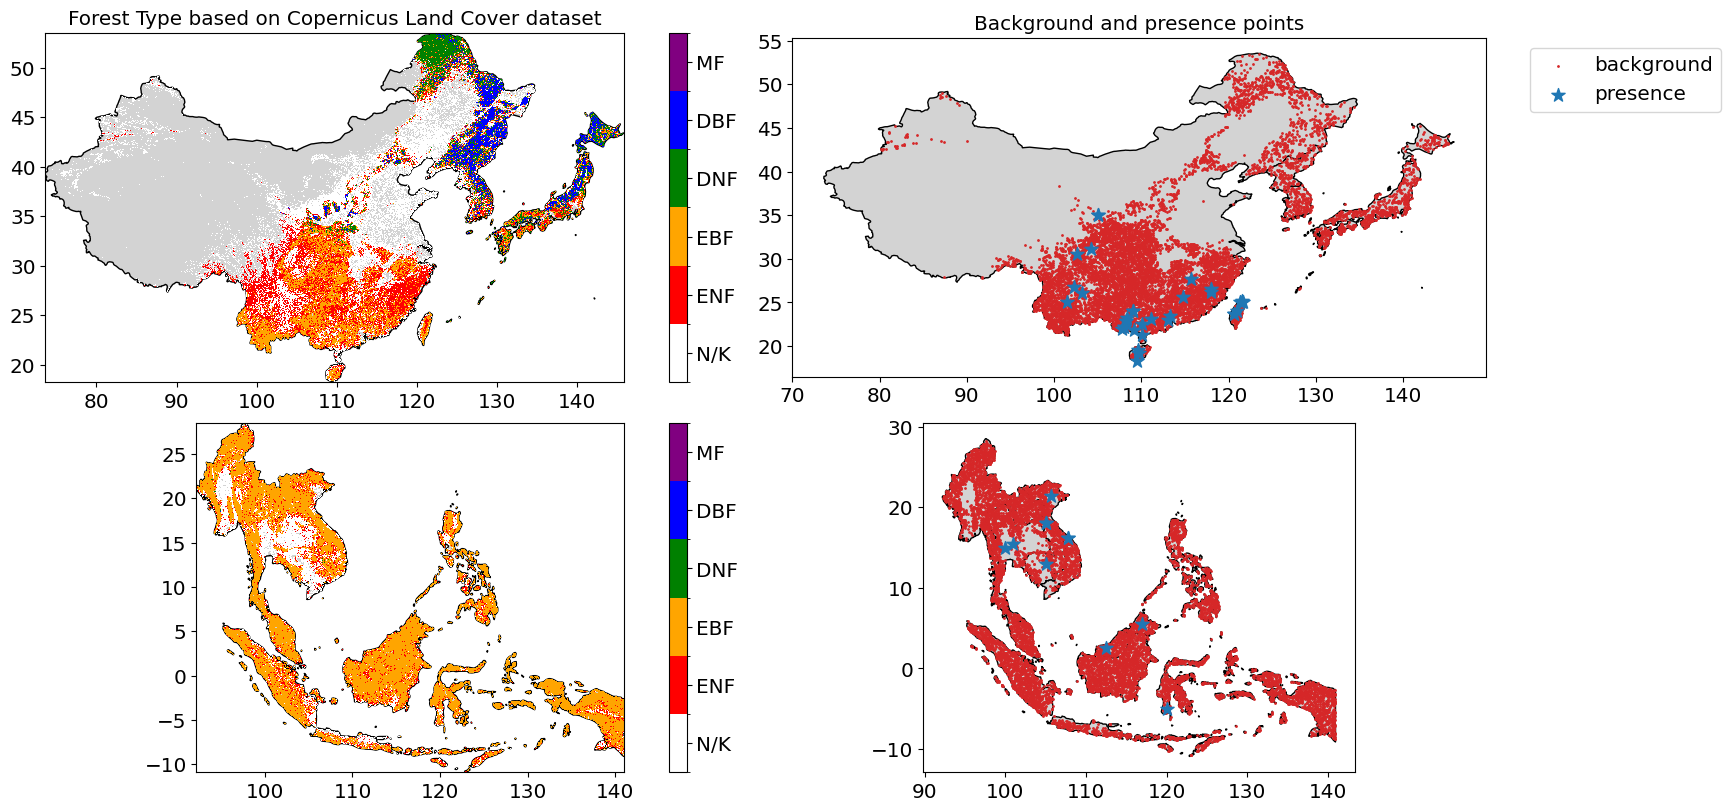

In [27]:
# fig, axes, gl = make_map(figsize=(18,6), projection=projection, res=resolution, ncols=2)

nrows, ncols = 2, 2
fig, axes = plt.subplots(figsize=(18,8), ncols=ncols, nrows=nrows, constrained_layout=True)

labels = [forest_dict[x][0] for x in forest_dict.keys()]
legend = [forest_dict[x][1] for x in forest_dict.keys()]

cmap_lc = mpl.colors.ListedColormap([forest_dict[x][3] for x in forest_dict.keys()])
# cmap.set_bad('transparent')
norm_lc = mpl.colors.BoundaryNorm(np.arange(-0.5,6), cmap_lc.N) 
fmt = mpl.ticker.FuncFormatter(lambda x, pos: labels[norm_lc(x)])

for iax in range(axes.size):
    r, c = iax // ncols, iax % ncols
    if r == 0:
        gdf_countries[training].plot(ax=axes[0, c], facecolor='lightgray', edgecolor='k')
    if r == 1:
        gdf_countries[interest].plot(ax=axes[1, c], facecolor='lightgray', edgecolor='k')

pcol = land_cover_regions[training].plot(ax=axes[0, 0], cmap=cmap_lc, norm=norm_lc, add_colorbar=False, add_labels=False)
plt.colorbar(pcol, format=fmt, ticks=np.linspace(0,5,6))
pcol = land_cover_regions[interest].plot(ax=axes[1, 0], cmap=cmap_lc, norm=norm_lc, add_colorbar=False, add_labels=False)
plt.colorbar(pcol, format=fmt, ticks=np.linspace(0,5,6))
axes[0, 0].set_title('Forest Type based on Copernicus Land Cover dataset')

scat = pseudoabsence_bias_land_cover[training].plot(ax=axes[0, 1], markersize=1, color='tab:red', label='background')
occurences[training].plot(ax=axes[0, 1], marker='*', markersize=100, color='tab:blue', label='presence')
pseudoabsence_bias_land_cover[interest].plot(ax=axes[1, 1], markersize=1, color='tab:red', label='background')
occurences[interest].plot(ax=axes[1, 1], marker='*', markersize=100, color='tab:blue', label='presence')
axes[0, 1].set_title('Background and presence points')
axes[0, 1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


In [28]:
if savefig:
    fig.savefig(os.path.join(figs_path, '02_background_biased-land-cover_%s_%s_%s.png' %(specie, training, interest)), transparent=True)

In [29]:
# fig, ax = plt.subplots(figsize=(8, 6))

# gdf_countries[training].plot(ax=ax, facecolor='lightgray', edgecolor='k')
# ax.axis('off')

# # pcol = land_cover_regions[training].plot(ax=ax, cmap=cmap_lc, norm=norm_lc, add_colorbar=False, add_labels=False)
# # fig.colorbar(pcol, format=fmt, ticks=np.linspace(0,5,6), fraction=0.02)
# # ax.set_title('Forest Type based on Copernicus Land Cover dataset')
# # fig.savefig(os.path.join(docs_path, '02.1_background-points_biased-forest-type_%s.png' %training), transparent=True, dpi=600)

# scat = pseudoabsence_bias_land_cover[training].plot(ax=ax, markersize=1, color='tab:red', label='background')
# occurences[training].plot(ax=ax, marker='*', markersize=100, color='tab:blue', label='presence')
# ax.legend(loc='lower left')
# ax.set_title('Background and presence points')
# fig.savefig(os.path.join(docs_path, '02.2_background-points_biased-forest-type_%s.png' %training), transparent=True, dpi=600)


### 2.2 Biased towards planted forest East Asia (Abbasi et al. 2023)
https://www.nature.com/articles/s41597-023-02383-w

In [30]:
region = 'east-asia'

In [31]:
forest_type_dict = {
    'Tropical Forest and Savanna': 0,#0.8
    'Temperate Forest': 0,#0.4
    'Eucalyptus': 1
}

In [32]:
forest_type_bias_file = os.path.join(train_path, 'forest-type_biased_%s.tif' %region)
if not os.path.isfile(forest_type_bias_file):
 
    planted_forest_file = os.path.join('zip://', data_path, 'planted-forest-east-asia', 'planted-forest-east-asia.zip')

    # planted_eucalyptus = gpd.read_file(planteplanted_forest_file, where="Genus='Eucalyptus'")
    tropical_forest = gpd.read_file(planted_forest_file, where="Biome='Tropical Forest and Savanna'", include_fields=['Biome', 'Genus', 'Type'])
    temperate_forest = gpd.read_file(planted_forest_file, where="Biome='Temperate Forest'", include_fields=['Biome', 'Genus', 'Type'])
    forest_type_region = pd.concat([tropical_forest, temperate_forest])


    # indicate likelihood that specie occurs in Genus or Biome type type with a number between 0 and 1
    # changes flag values to normalised and weighted
    forest_type_region['norm'] = 0
    for key, val in forest_type_dict.items():
        forest_type_region.loc[forest_type_region.Biome == key, 'norm'] = val
        if key == 'Eucalyptus':
            forest_type_region.loc[forest_type_region.Genus == key, 'norm'] = val
#         temperate_forest.loc[
#             temperate_forest['potential'] = 0.5
#             temperate_forest.loc[temperate_forest.Genus == 'Eucalyptus', 'potential'] = 1
#             tropical_forest['potential'] = 1
    
    # rasterize vector data
    forest_type_raster = make_geocube(
    vector_data=forest_type_region,
    measurements=['norm'],
    resolution=(0.01, -0.01),#0.0174532925199433
#     fill = 0
    )
    
    # save raster to file
    forest_type_raster.rio.to_raster(forest_type_bias_file)
else:
    forest_type_raster = rioxr.open_rasterio(forest_type_bias_file)
    
pseudoabsence_bias_forest = ela.sample_bias_file(forest_type_bias_file, count=count)

print('Number of presences in %s is: %s' %(region, len(occurences[region])))
print('Number of background points with a bias towards forests in %s is: %s' %(region, len(pseudoabsence_bias_forest)))

Number of presences in east-asia is: 36
Number of background points with a bias towards forests in east-asia is: 10000


In [33]:
# save background points to file
pseudoabsence_bias_forest = pseudoabsence_bias_forest.to_frame(name='geometry')
pseudoabsence_bias_forest['lon'] = pseudoabsence_bias_forest['geometry'].x
pseudoabsence_bias_forest['lat'] = pseudoabsence_bias_forest['geometry'].y
pseudoabsence_bias_forest.to_csv(os.path.join(train_path, '%s_background_biased_forest-type_%s.csv' %(specie, region)), columns=['lon', 'lat'], index=False)

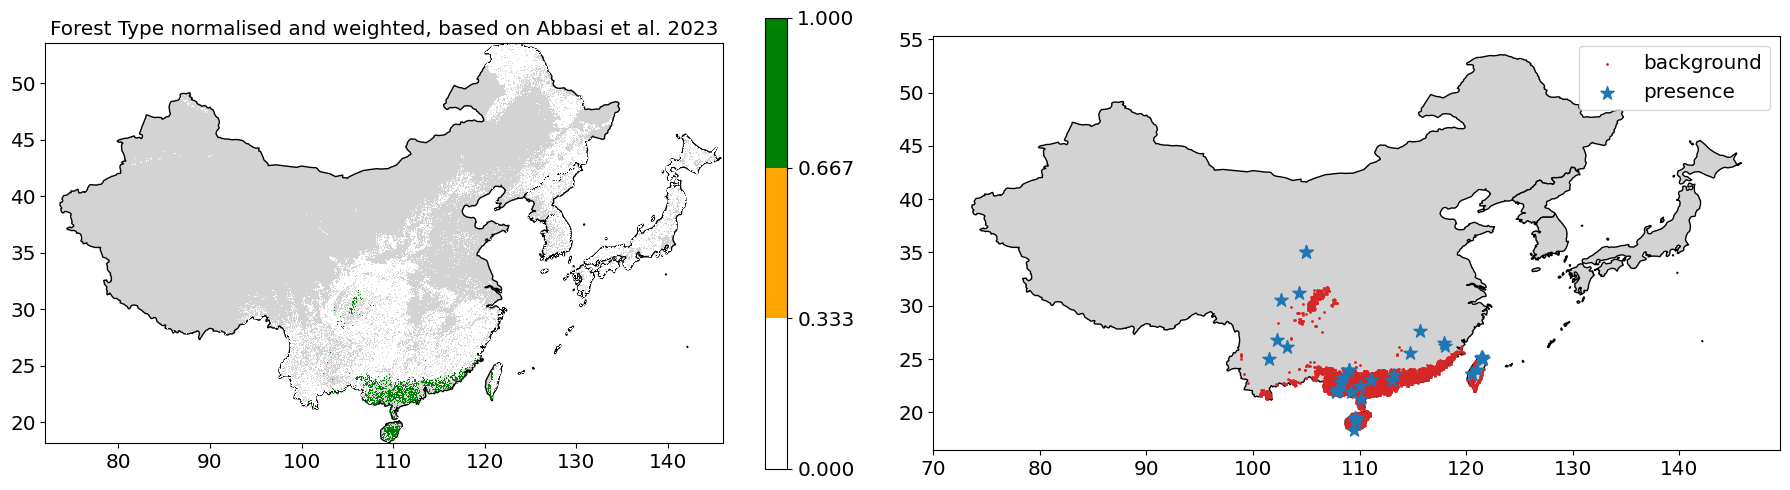

In [34]:
# fig, axes, gl = make_map(figsize=(18,6), projection=projection, res=resolution, ncols=2)
fig, axes = plt.subplots(figsize=(18,5), ncols=2)

cmap_ft = mpl.colors.ListedColormap(['white', 'orange', 'green'])
cmap_ft.set_bad('k', alpha=0)
bounds=[0,.333,.667,1]
norm_ft = mpl.colors.BoundaryNorm(bounds, cmap_ft.N)

gdf_countries[region].plot(ax=axes[0], facecolor='lightgray', edgecolor='k')
try:
    pcol = forest_type_raster.norm.plot(ax=axes[0], cmap=cmap_ft, norm=norm_ft, add_colorbar=False, add_labels=False)
except AttributeError:
    pcol = forest_type_raster.plot(ax=axes[0], cmap=cmap_ft, norm=norm_ft, add_colorbar=False, add_labels=False)

plt.colorbar(pcol)
axes[0].set_title('Forest Type normalised and weighted, based on Abbasi et al. 2023')
axes[0].set_xlim(72, 146)
    
gdf_countries[region].plot(ax=axes[1], facecolor='lightgray', edgecolor='k')
pseudoabsence_bias_forest.plot(ax=axes[1], markersize=1, color='tab:red', label='background')
occurences[region].plot(ax=axes[1], marker='*', markersize=100, color='tab:blue', label='presence')
axes[1].legend()

plt.tight_layout()

In [35]:
if savefig:
    fig.savefig(os.path.join(figs_path, '02_background_biased-forest-type_%s_%s.png' %(specie, region)), transparent=True)

In [36]:
# fig, ax = plt.subplots(figsize=(8, 6))

# gdf_countries[training].plot(ax=ax, facecolor='lightgray', edgecolor='k')
# ax.axis('off')

# cmap_ft = mpl.colors.ListedColormap(['white', 'green'])
# cmap_ft.set_bad('k', alpha=0)
# bounds = np.arange(-0.5,2) #[-0.5, 0.5, 1]
# norm_ft = mpl.colors.BoundaryNorm(bounds, cmap_ft.N)
# fmt = mpl.ticker.FuncFormatter(lambda x, pos: [0, 1][norm_ft(x)])

# gdf_countries[region].plot(ax=ax, facecolor='lightgray', edgecolor='k')
# try:
#     pcol = forest_type_raster.norm.plot(ax=ax, cmap=cmap_ft, norm=norm_ft, add_colorbar=False, add_labels=False)
# except AttributeError:
#     pcol = forest_type_raster.plot(ax=ax, cmap=cmap_ft, norm=norm_ft, add_colorbar=False, add_labels=False)
# ax.set_title('Forest Type normalised and weighted, based on Abbasi et al. 2023')
# ax.set_xlim(72, 146)
# fig.colorbar(pcol, format=fmt, ticks=np.linspace(0,1,2), fraction=0.02)
# fig.savefig(os.path.join(docs_path, '02.3_background-points_biased-abbasi2023_%s.png' %training), transparent=True, dpi=600)

# # scat = pseudoabsence_bias_forest.plot(ax=ax, markersize=1, color='tab:red', label='background')
# # occurences[region].plot(ax=ax, marker='*', markersize=100, color='tab:blue', label='presence')
# # ax.legend(loc='lower left')
# # ax.set_title('Background and presence points')
# # fig.savefig(os.path.join(docs_path, '02.4_background-points_biased-abbasi2023_%s.png' %training), transparent=True, dpi=600)
